In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
import scipy
!pip install mycolorpy

  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3853 sha256=dbbed2aa1d20eca6554d7e1494f01f3572774fc64816821520a53c675bb3771b
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


# Generazione Dati

In [10]:
from IPython.utils.sysinfo import num_cpus

# numero di cluster
K=5

# dimensione del campione
d=2

# numero di sample
N=1000

seed=2022
key = random.PRNGKey(seed)
# vectors of mean of clusters
sigma=5
mu=random.normal(key,(K,d))*sigma

# cluster assignment
key = random.PRNGKey(2)
c=random.categorical(key,(1/K)*jnp.ones(shape=(K,)),axis=0,shape=(N,))
C=np.zeros(shape=(N,K))
for i in range(N):
  C[i,c[i]]=1
C=jnp.array(C)

# Data
X=jnp.matmul(C,mu)+random.normal(key,(N,d))

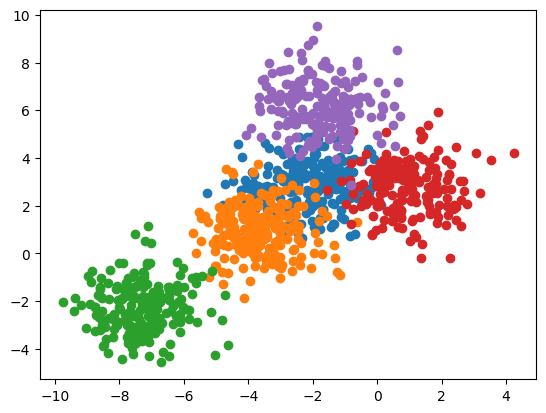

In [3]:
import matplotlib.pyplot as plt

for i in range(K):
  plt.scatter(X[c==i,0],X[c==i,1])
plt.show()

# Variational Inference

We construct the model for our VI algorithm, we stick to the notation of the paper. Our model is described by:

\begin{align*}
    \mu_k\ \mid x &\stackrel{\tiny\mbox{ind}}{\sim} \mathcal{N}_d\left(m_k, s^2_k\ \mathbb{I}_d\right) \qquad \qquad \ \ \  k=1,...,K\\
    x_i \mid c_i,μ &\stackrel{\tiny\mbox{ind}}{\sim} \mathcal{N}_d\left(c^T_iμ, \ \mathbb{I}_d\ \right) \qquad  \qquad \ \ \ \  i=1,...,n \\
    \mu_k &\stackrel{\tiny\mbox{iid}}{\sim}\mathcal{N}_d\left(0, \ \sigma^2\  \mathbb{I}_d\right) \qquad \qquad \ \ \ \   k=1,...,K\\
    c_ i&\stackrel{\tiny\mbox{iid}}{\sim} Cat(\frac{1}{K},...,\frac{1}{K}) \qquad \qquad  i=1,...,n
\end{align*}




Considering $q(c_i=k)$=$𝝋_{ik}$ we can define the variational update for the ith cluster assignment as

\begin{align*}
  𝜑_{ik}∝exp[\ \mathbb{E}[\mu_k;\ m_k,\ s_k^2]x_i-\mathbb{E}[\mu_k^2;\ m_k,\ s_k^2]/2\ ]
\end{align*}

Then we can define the updates for the variational density of the kth mixture component q($\mu_k$) in terms of variational mean and variance


\begin{align*}
    \hat{m_k}=\frac{\sum_{i}^{}𝝋_{ik}x_i}{\frac{1}{\sigma^2}+\sum_{i}^{}𝝋_{ik}} \qquad \qquad \hat{s_k}^2=\frac{1}{\frac{1}{\sigma^2}+\sum_{i}^{}𝝋_{ik}}
\end{align*}


VI can be considered as an optimization problem, so we need to define the function to be optimized, which is the ELBO.
\begin{align*}
    ELBO(\hat{m},\hat{s}^2,𝜑)=\sum_{k=1}^{K}\mathbb{E}[\log p(\mu_k);\ \hat{m_k},\ \hat{s_k}^2] \  +\\  \sum_{i=1}^{n}(\ \mathbb{E}[\log p(c_i);\ 𝜑_i]+\mathbb{E}[\log p(x_i|c_i,μ);\ 𝜑_i,\ \hat{m},\ \hat{s}^2]\ )\ + \  \\ - \sum_{i=1}^{n} \mathbb{E}[\log q(c_i;\ 𝜑_i)]- \sum_{k=1}^{K} \mathbb{E}[\log q(\mu_k;\ \hat{m_k},\ \hat{s_k}^2)]
\end{align*}

\\
Considering $k=1,...,K$ and $i=1,...,n$

In [39]:

#def update_phi(data,phi,m,s2):
#  for i in jnp.arange(data.shape[0]):
#    for k in jnp.arange(phi.shape[1]):
#      phi[i,k]=jnp.exp(jnp.matmul(m[k,:],data[i,:].transpose())-(s2[k]+jnp.matmul(m[k,:],m[k,:].transpose()))/2) # non sono così sicuro della formula per mk^2
#    phi[i,:]=phi[i,:]/jnp.sum(phi[i,:])
#  return phi

def update_phi(data, phi, m, s2):
    updated_phi = jnp.zeros_like(phi)
    M=jnp.matmul(m,m.T)
    log_likelihood = jnp.matmul(data,m.T) - 0.5 * jnp.matmul(jnp.ones(shape=(N,1)),(s2.T + jnp.resize(jnp.diag(M),(K,1)).T))
    # updated_phi=scipy.special.softmax(log_likelihood)
    updated_phi = jnp.exp(log_likelihood) + 10**-16 # to avoid round zeros that make the ELBO go nan

    updated_phi /= jnp.sum(updated_phi,axis=1,keepdims=True)
    return updated_phi

update_phi_jit=jit(update_phi)


def update_mean_and_variance(data,phi,sigma):
  K=phi.shape[1]
  d=data.shape[1]
  N=data.shape[0]
  updated_m=(jnp.matmul(phi.T,data)/(1/sigma**2*jnp.ones(shape=(K,d))+jnp.matmul(jnp.resize(jnp.sum(phi,axis=0),(1,K)).T,jnp.ones(shape=(1,d)))))
  updated_s2=(1/(1/sigma**2*jnp.ones(shape=(K,1))+jnp.resize(jnp.sum(phi,axis=0),(1,K)).T))
  return updated_m,updated_s2

update_mean_and_variance_jit=jit(update_mean_and_variance)


def compute_ELBO(m,s2,phi,data):
  # when computing the ELBO value, we omit constants because once we compute the improvement they would have a total of 0
  # Fn stands for the nth component of the formula (21) in the review paper
  d=m.shape[1]
  M=jnp.matmul(m,m.T)

  F1=-0.5/sigma**2 *jnp.sum( d*s2+jnp.diag(M))

  # F2= -log(K) sum over k from 1 to K => constant in every iteration

  F3=-0.5*jnp.sum(jnp.matmul(phi.T,jnp.diag(jnp.matmul(data,data.T))))+jnp.sum(jnp.diag(jnp.matmul(phi.T,jnp.matmul(data,m.T))))-0.5*d*jnp.sum(jnp.matmul(phi,s2))
  F3+=-0.5*jnp.sum(jnp.matmul(phi,jnp.diag(M)))
  # -d/2*jnp.log(2*jnp.pi)*phi[i,k] summed over i and k should be constant over time, since phi[i,:] is a probability it should sum N every time

  F4=jnp.sum(jnp.log(phi)*phi)

  F5=-d/2*jnp.sum(jnp.log(s2))

  return F1+F3-F4-F5

compute_ELBO_jit=jit(compute_ELBO)


In [36]:
# FUNCTION FOR VARIATIONAL INFERENCE
# Notation of the paper

def single_iteration_VI(data,K,sigma,i,nMAX,tol):
    N=data.shape[0]
    d=data.shape[1]
    key = random.PRNGKey(i*seed)
    phi=random.uniform(key,minval=0,maxval=1,shape=(N,K))
    phi/=jnp.sum(phi,axis=1,keepdims=True)
    m=random.normal(key,shape=(K,d))*sigma
    s2=random.uniform(key,minval=0,maxval=10,shape=(K,1))
    improvement=1
    ELBO_old=0 # probabilmente questo andrà modificato
    ELBO_new=compute_ELBO_jit(m,s2,phi,data)
    nit=0
    while (improvement>tol and nit<nMAX): # or nit<15:
      phi=update_phi_jit(data,phi,m,s2)
      m,s2=update_mean_and_variance_jit(data,phi,sigma)
      ELBO_old=ELBO_new
      ELBO_new=compute_ELBO_jit(m,s2,phi,data)
      improvement=ELBO_new-ELBO_old
      nit+=1
      #print('Iter ',nit,'\t ELBO: ',ELBO_new,'\t Improvement: ',improvement,'\n')
      #print('=================================================\n')
    return  m,s2,phi,ELBO_new,nit

single_iteration_VI_jit=jit(single_iteration_VI,static_argnames=['K','nMAX','tol'])


def VI(data,K,sigma,nMAX,n_iniz,tol):
  # creating our variables as estimation of parameters for posterior probabilities
  # jax arrays are immutable, so I don't know how to create these variables in jax and use them
  # I iniialize them randomly, since there is no a-priori starting point which is best than others
  ELBO_max=0
  for i in range(n_iniz):
    m,s2,phi,ELBO_new,nit=single_iteration_VI(data,K,sigma,i,nMAX,tol)
    if i==0:
      ELBO_max=ELBO_new
      m_max=m
      s2_max=s2
      phi_max=phi
      n_max=0
    print('Initialization number: ',i+1,'\t ELBO: ',ELBO_new,'\t N_iterations: ',nit)
    print('=================================================\n')
    if ELBO_new>ELBO_max:
      ELBO_max=ELBO_new
      m_max=m
      s2_max=s2
      phi_max=phi
      n_max=i
  print('Best initialization at ',n_max+1,' \t ELBO: ',ELBO_max,'\n\n')
  return m_max,s2_max,phi_max

VI_jit=jit(VI)


In [6]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp

def plot_clusters(data, phi, means):
    # Get the cluster assignments
    cluster_assignments = jnp.argmax(phi, axis=1)

    # Number of clusters
    num_clusters = means.shape[0]

    # Create a list of colors for plotting
    #colors = plt.colormaps()
    colors=mcp.gen_color(cmap="viridis",n=K)
    print(colors)

    # Scatter plot each data point with its assigned color
    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        plt.scatter(data[cluster_assignments == cluster, 0], data[cluster_assignments == cluster, 1], c=colors[cluster], label=f'Cluster {cluster}')

    # Plot the cluster means
    for cluster in range(num_clusters):
        plt.scatter(means[cluster, 0], means[cluster, 1], marker='x', color='red', s=100, label=f'Mean Cluster {cluster}')

    plt.legend()
    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [43]:
# %%timeit
tol=10**-16
m,s2,phi=VI(X,K,sigma,10000,100,tol)
#print(m,'\n',mu)
#print(s2)
#print(phi,'\n',C)

Initialization number:  1 	 ELBO:  -832.8182 	 N_iterations:  22

Initialization number:  2 	 ELBO:  -832.82056 	 N_iterations:  10

Initialization number:  3 	 ELBO:  -988.8865 	 N_iterations:  32

Initialization number:  4 	 ELBO:  -832.8243 	 N_iterations:  28

Initialization number:  5 	 ELBO:  -900.9256 	 N_iterations:  19

Initialization number:  6 	 ELBO:  -832.8166 	 N_iterations:  20

Initialization number:  7 	 ELBO:  -832.82104 	 N_iterations:  25

Initialization number:  8 	 ELBO:  -832.82587 	 N_iterations:  26

Initialization number:  9 	 ELBO:  -988.8942 	 N_iterations:  31

Initialization number:  10 	 ELBO:  -832.8169 	 N_iterations:  17

Initialization number:  11 	 ELBO:  -832.8215 	 N_iterations:  33

Initialization number:  12 	 ELBO:  -988.8898 	 N_iterations:  18

Initialization number:  13 	 ELBO:  -832.8187 	 N_iterations:  18

Initialization number:  14 	 ELBO:  -988.8728 	 N_iterations:  21

Initialization number:  15 	 ELBO:  -988.8938 	 N_iterations:  15

I

['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']


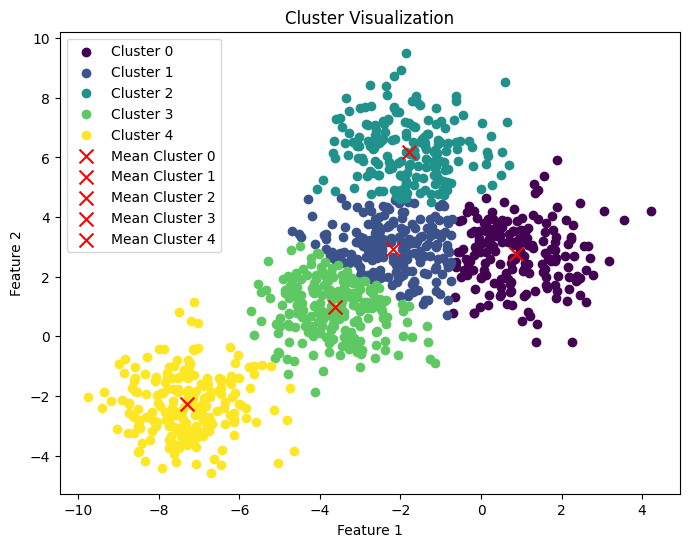

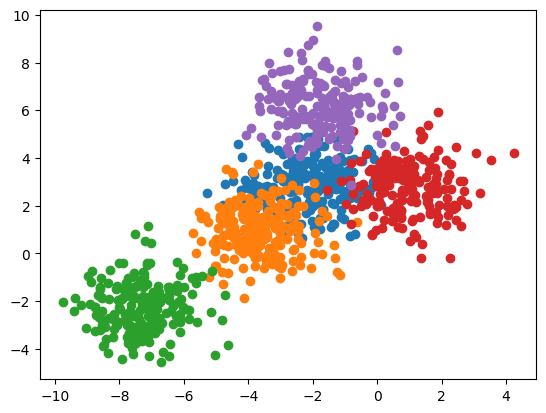

In [42]:
# Eslicitiamo la likehood di muk rispetto ai dati
n_cluster = np.sum(C, axis = 0)
m_post=1/(1+1/sigma**2)/np.matmul(n_cluster.reshape((K,1)),np.ones(shape=(1,d)))*np.matmul(C.T,X)
s2_post=1/(1+1/sigma**2)/n_cluster

plot_clusters(X, phi, m)

for i in range(K):
  plt.scatter(X[c==i,0],X[c==i,1])
plt.show()

WORK IN PROGRESS

Il codice che segue è un'idea di metrica di errore, per ora non utilizzabile perchè nel caso volessimo implementarlo correttamente dovremmo riuscire a abbinare i cluster iniziali con quelli dell'algoritmo perchè l'ordine non si mantiene

In [ ]:
def error_measure(m_real,s2_real,clus_real,m_pred,s2_pred,clus_pred):
  N=clus_real.shape[0]
  K=m_real.shape[0]
  error_m=1/K*jnp.linalg.norm(m_real-m_pred)
  error_s2=1/K*jnp.linalg.norm(s2_real-s2_pred)
  error_clust=1/N*jnp.count_nonzero(clus_real-clus_pred)
  return error_m,error_s2,error_clust

In [ ]:
clus_pred=jnp.reshape(jnp.argmax(phi,axis=1,keepdims=True),(N,))
error_m,error_s2,error_clust=error_measure(m_post,s2_post,c,m,s2,clus_pred)
error_m,error_s2,error_clust

(Array(2.9955854, dtype=float32),
 Array(0.00043461, dtype=float32),
 Array(0.95300007, dtype=float32, weak_type=True))